In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow as tf

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.layers import Layer, Activation
from tensorflow.keras.optimizers import RMSprop

In [22]:
# Data directory
DATADIR = 'UCI HAR Dataset'

In [ ]:
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [ ]:
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'{DATADIR}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 

    return np.transpose(signals_data, (1, 2, 0))

In [ ]:
def load_y(subset):
    filename = f'{DATADIR}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

In [ ]:
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [28]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [ ]:
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [ ]:
X_train, X_test, Y_train, Y_test = load_data()

In [31]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [32]:
X_train.shape

(7352, 128, 9)

In [33]:
# TCN Layer
def TCN(input_layer, filters, kernel_size=3, dilation_rate=1):
    x = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(input_layer)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')(x)
    x = Activation('relu')(x)
    return x


In [35]:
# Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units
        self.query_dense = Dense(units)
        self.key_dense = Dense(units)
        self.value_dense = Dense(units)

    def call(self, inputs):
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = attention_scores / tf.math.sqrt(tf.cast(self.units, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output


In [ ]:
input_layer = Input(shape=(timesteps, input_dim))

tcn_output = TCN(input_layer, filters=64, kernel_size=3, dilation_rate=2)

attention_output = SelfAttention(units=64)(tcn_output)

x = GlobalAveragePooling1D()(attention_output)

x = Dropout(0.5)(x)

output_layer = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 9)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 128, 64)           1792      
                                                                 
 activation_2 (Activation)   (None, 128, 64)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 128, 64)           12352     
                                                                 
 activation_3 (Activation)   (None, 128, 64)           0         
                                                                 
 self_attention_1 (SelfAtten  (None, 128, 64)          12480     
 tion)                                                           
                                                           

In [ ]:
model.fit(X_train, Y_train, batch_size=16, epochs=30, validation_data=(X_test, Y_test))


Epoch 1/30
460/460 [==============================] - 12s 20ms/step - loss: 0.5046 - accuracy: 0.8025 - val_loss: 0.6161 - val_accuracy: 0.7920
Epoch 2/30
460/460 [==============================] - 7s 16ms/step - loss: 0.1911 - accuracy: 0.9309 - val_loss: 0.4140 - val_accuracy: 0.8826
Epoch 3/30
460/460 [==============================] - 8s 18ms/step - loss: 0.1535 - accuracy: 0.9429 - val_loss: 0.4297 - val_accuracy: 0.8843
Epoch 4/30
460/460 [==============================] - 7s 15ms/step - loss: 0.1402 - accuracy: 0.9446 - val_loss: 0.4798 - val_accuracy: 0.8856
Epoch 5/30
460/460 [==============================] - 8s 18ms/step - loss: 0.1250 - accuracy: 0.9499 - val_loss: 0.5442 - val_accuracy: 0.8897
Epoch 6/30
460/460 [==============================] - 7s 15ms/step - loss: 0.1203 - accuracy: 0.9512 - val_loss: 0.4660 - val_accuracy: 0.9026
Epoch 7/30
460/460 [==============================] - 8s 18ms/step - loss: 0.1165 - accuracy: 0.9504 - val_loss: 0.5694 - val_accuracy: 0.887

93/93 [==============================] - 1s 9ms/step - loss: 1.4517 - accuracy: 0.8965
Accuracy: 0.8965049386024475
Loss: 1.4517269134521484
93/93 [==============================] - 1s 8ms/step


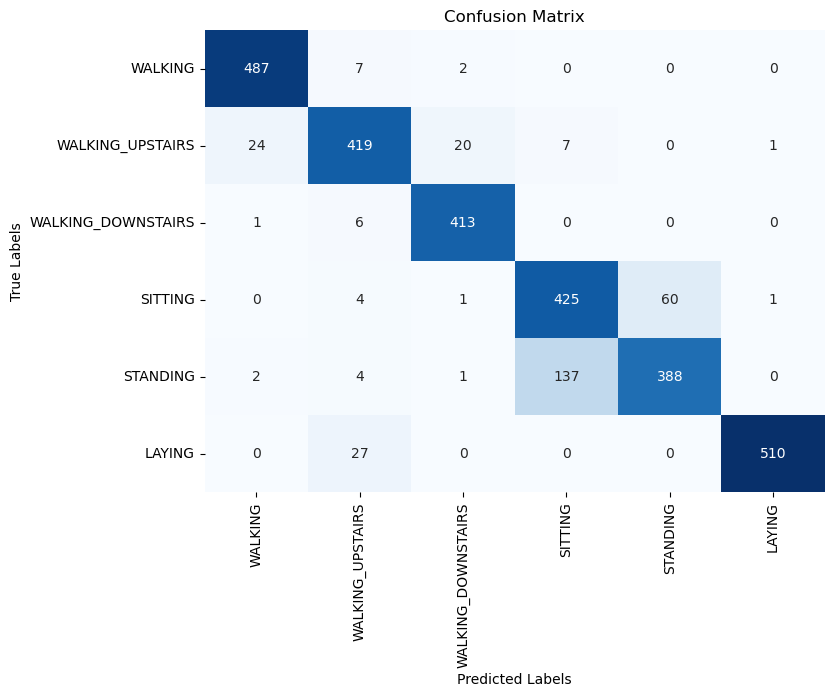

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

score = model.evaluate(X_test, Y_test)
print(f"Accuracy: {score[1]}")
print(f"Loss: {score[0]}")

y_pred = model.predict(X_test)
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(y_pred, axis=1))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"], yticklabels=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"], cbar=False)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.show()
